# In search of the optimal stable marriage

In [1]:
from assignment import *
%store -r

## Background
### One-to-one assignment problems and stable assignment

A one-to-one assignment problem involves a set of two groups, *candidates* and *reviewers,* each of whom has ranked the members of the other group on the basis of how much they would like to be paired together. An *assignment* is a set of pairs $a_k = (i_k, j_k)$ consisting of one candidate $i$ and one reviewer $j$ such that no candidate or reviewer is assigned to more than one partner.

Our goal is to find an assignment that is mutually acceptable to both parties. In the classical formulation, the groups are *men* and *women* to be married, and we seek a *stable assignment,* meaning one in which no member of either group is incentivized to cheat on their partner. Such an incentive is provided when an assignment excludes one or more *blocking pairs,* pairings that both parties prefer to the partner currently assigned to them.

For example, in the following example, candidate 1&rsquo;s 0th choice is reviewer 1, while reviewer 1&rsquo;s 1st is candidate 1. If an assignment contains the pairs $(1, 2)$ and $(0, 1)$, then candidate 1 and reviewer 1 each prefer to be together than with their current assignment: $(1, 1)$ is a blocking pair, and the assignment is unstable.

(Throughout this discussion, I will refer to what we would colloquially call someone&rsquo;s &ldquo;first&rdquo; or &ldquo;second&rdquo; choices as their 0th and 1st choices respectively, which conforms to Python&rsquo;s zero-based indexing system.)

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Candidates'}>,
        <AxesSubplot:title={'center':'Reviewers'}>], dtype=object))

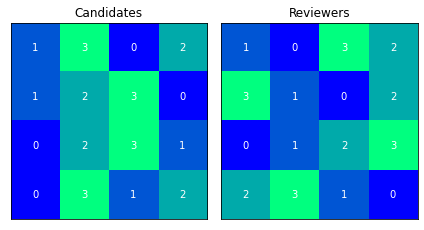

In [2]:
candidates = [[1, 3, 0, 2], [1, 2, 3, 0], [0, 2, 3, 1], [0, 3, 1, 2]]
reviewers = [[1, 0, 3, 2], [3, 1, 0, 2], [0, 1, 2, 3], [2, 3, 1, 0]]

assn_inst = assignment(candidates, reviewers)
viz_prefs(candidates, reviewers, kwargs={'figsize': (6, 4)})

### The proposal algorithm

A famous result holds that the Gale-Shapely, or *proposal,* algorithm produces a stable assignment. The algorithm works as follows:

1. At the beginning of each round, each candidate proposes to the reviewer at the top of their list.
2. The reviewers examine the proposals they received. If they received proposals from multiple candidates, they reject all but the one most favorable to them.
3. The rejected candidates remove the reviewers who rejected them from their list.

This procedure is repeated until no rejections occur; then the set of pairs $(i,j)$ where $j$ is the reviewer highest on $i$&rsquo;s reduced list forms a stable assignment.

The proposal algorithm possesses several desirable properties. First, since at least one rejection occurs in every round, and no rejection can occur more than once, the algorithm is guaranteed to terminate in at most $n^2$ iterations ($nm$ when there are different numbers of candidates and reviewers).

Second, the proposal algorithm can be used without modification when there are different numbers of candidates and reviewers. It can also be used unmodified if each candidate ranks only the subset of reviewers they find acceptable (or vice-versa), signifying that they would rather be assigned to no partner (called a desk reject or celibacy option) than be assigned to one of the participants they omitted.

With slight modifications to steps 1 and 2 above, the algorithm can also perform many-to-one or one-to-many assignment; however, the resultant assignments are not necessarily stable (Baïou and Balinski 2000).

Let&rsquo;s apply the proposal algorithm to the example above.

In [3]:
assn_inst.proposal(verbose=True)

Reduced candidate lists:
[[1, 3, 0, 2], [1, 2, 3, 0], [0, 2, 3, 1], [0, 3, 1, 2]]
Results of round 0:
  Candidate 2 proposed to reviewer 0
  Candidate 3 proposed to reviewer 0
    Reviewer 0 rejected candidate 2
  Candidate 0 proposed to reviewer 1
  Candidate 1 proposed to reviewer 1
    Reviewer 1 rejected candidate 0
Reduced candidate lists:
[[3, 0, 2], [1, 2, 3, 0], [2, 3, 1], [0, 3, 1, 2]]
Results of round 1:
  Candidate 3 proposed to reviewer 0
  Candidate 1 proposed to reviewer 1
  Candidate 2 proposed to reviewer 2
  Candidate 0 proposed to reviewer 3


([(0, 3), (1, 1), (2, 2), (3, 0)],
 [[3, 0, 2], [1, 2, 3, 0], [2, 3, 1], [0, 3, 1, 2]])

This stable assignment contains the pairs $(0, 3), (1, 1), (2, 2),$ and $(3, 0)$. We can compute the *cost* of this assignment by adding the ranks associated with each pairing. Candidate 0 is paired with reviewer 3, who he has ranked 1. Reviewer 3 has ranked candidate 0 at the top of her list, rank 0. Thus the cost associated with the pair $(0,3)$ is $1+0 = 1$. Summing the costs for each pair in the overall assignment yields the overall cost; lower is better, and if everyone is assigned to their &ldquo;perfect match,&rdquo; the overall cost is zero.

In our example, the cost associated with candidate-optimal stable assignment is 10, and the cost associated with the reviewer-optimal stable assignment is also 10 (a coincidence).

In [4]:
assn_inst.cost(), assn_inst.cost(reverse=True)

(10, 10)

## Exploring the set of stable assignments

### Candidate- and reviewer-optimal assignments

The proposal algorithm finds only one stable assignment, and it can be shown that the one it finds is *candidate optimal*&mdash;that is, any assignment that pairs a candidate with a reviewer ranked higher in their list than the candidate assigned by the proposal algorithm is an unstable assignment. Moreover, it can be shown that the candidate-optimal assignment is *reviewer pessimal:* if another stable assignment exists in the problem, it will provide better (from the reviewers&rsquo; perspective) partners to some or all of the reviewers.

A reviewer-optimal (and candidate-pessimal) assignment can be found by interchanging the roles of the candidates and reviewers and running the algorithm again, like so:

In [5]:
assn_inst.proposal(reverse=True, verbose=True)

Reduced candidate lists:
[[1, 0, 3, 2], [3, 1, 0, 2], [0, 1, 2, 3], [2, 3, 1, 0]]
Results of round 0:
  Candidate 2 proposed to reviewer 0
  Candidate 0 proposed to reviewer 1
  Candidate 3 proposed to reviewer 2
  Candidate 1 proposed to reviewer 3


([(0, 1), (1, 3), (2, 0), (3, 2)],
 [[1, 0, 3, 2], [3, 1, 0, 2], [0, 1, 2, 3], [2, 3, 1, 0]])

### The rotation algorithm

Some assignment problems admit only one stable assignment, in which case the proposal algorithm yields the same results when reversed. However, this particular assignment problem contains distinct candidate- and reviewer-optimal solutions, along with two additional, intermediate stable solutions. We can find all four stable assignments using the *rotation algorithm* (Irving et al. 1987). 

The rotation algorithm begins by taking the reduced preference lists produced by the (candidate-led) proposal algorithm, and applying the observation that these preferences are reviewer pessimal to produce (candidate-oriented) *shortlists.* From each reviewer&rsquo;s perspective, the candidate assigned by the proposal algorithm is the worst they should ever have to settle for; thus, we can cross off any candidates from the reviewers&rsquo; lists who are worse than their proposal assignment. Likewise, we can remove those reviewers where they appear in the lists of the candidates they cross off.

The shortlists for our example are as follows. Notice that both the candidates&rsquo; and reviewers&rsquo; lists are reduced.

In [6]:
assn_inst.shortlists()

([[3, 0, 2], [1, 2, 3, 0], [2, 3], [0, 3, 1]],
 [[1, 0, 3], [3, 1], [0, 1, 2], [2, 3, 1, 0]])

In [7]:
# cf.
candidates, reviewers

([[1, 3, 0, 2], [1, 2, 3, 0], [0, 2, 3, 1], [0, 3, 1, 2]],
 [[1, 0, 3, 2], [3, 1, 0, 2], [0, 1, 2, 3], [2, 3, 1, 0]])

Let&rsquo;s examine the shortlists corresponding to candidates 0 and 3. 0&rsquo;s list is $[3,0,2]$ and 1&rsquo;s list is $[0,3,1]$. If we reassign candidate 0 to reviewer 0, and candidate 3 to reviewer 3, we can produce a new assignment. And this new assignment remains stable, because reviewer 0 prefers candidate 0 to candidate 3, and reviewer 3 prefers candidate 3 to candidate 0 (or else we crossed those candidates off when we created the shortlists). Thus, candidates 0 and 3 are members of a *rotation,* and when we *eliminate* that rotation by performing the reassignment described above, we produce a new stable assignment that is marginally more appealing to the reviewers and marginally less appealing to the candidates.

The net marginal cost is relatively easy to calculate: add the differences in ranks between the members of the rotation before and after elimination. Here, reassigning candidate 0 to reviewer 0 changes candidate 0&rsquo;s cost from 1 to 2, and reviewer 0&rsquo;s cost from 2 to 1. Reassigning candidate 3 to reviewer 3 changes candidate 3&rsquo;s cost from 0 to 1, and reviewer 3&rsquo;s cost from 3 to 1. The net decrease in cost, or the *weight* of the rotation, is

$$-\left[(2-1)+(1-2)+(1-0)+(1-3)\right] = 1$$

and the total cost of the assignment after eliminating this rotation decreases from 10 to 9.

After searching for rotations in this set of shortlists, we can eliminate all the rotations we find and produce a new set of shortlists. It may contain yet further rotations. We continue searching and eliminating until no rotations remain; at the end of this process, we arrive at the candidate-pessimal assignment, which is identical to the assignment produced by running the proposal algorithm in reverse.

In [8]:
assn_inst.rotate(verbose=True)

Generating shortlists
Reduced candidate lists:
[[1, 3, 0, 2], [1, 2, 3, 0], [0, 2, 3, 1], [0, 3, 1, 2]]
Results of round 0:
  Candidate 2 proposed to reviewer 0
  Candidate 3 proposed to reviewer 0
    Reviewer 0 rejected candidate 2
  Candidate 0 proposed to reviewer 1
  Candidate 1 proposed to reviewer 1
    Reviewer 1 rejected candidate 0
Reduced candidate lists:
[[3, 0, 2], [1, 2, 3, 0], [2, 3, 1], [0, 3, 1, 2]]
Results of round 1:
  Candidate 3 proposed to reviewer 0
  Candidate 1 proposed to reviewer 1
  Candidate 2 proposed to reviewer 2
  Candidate 0 proposed to reviewer 3

Finding rotations
C0's next choice is R0, currently matched with C3
C3's next choice is R3, currently matched with C0
  Found a rotation involving candidates [0, 3]
C1's next choice is R2, currently matched with C2
C2's next choice is R3, currently matched with C0

Eliminating rotations
  Eliminating rotation [0, 3], weight 1

Shortlists after eliminating rotations at depth 0
[[0, 2], [1, 2, 3, 0], [2, 3], [

([[(0, 3), (3, 0)], [(2, 2), (3, 3), (1, 1)], [(0, 0), (1, 2)]],
 [[(0, 3), (3, 0)], [(2, 2), (1, 3), (3, 3), (1, 1)], [(0, 0), (1, 2)]],
 [1, 0, -1],
 [0, 1, 2])

Not every combination of rotations corresponds to a stable assignment, as some rotations depend on others. We can represent the rotation dependencies using a directed graph. By using this graph to traverse the set of stable assignments, we can model the optimal stable assignment as a maximum-flow problem or a linear program.

In our simple example, the dependencies among the rotations are as follows. Each node corresponds to a rotation, and its label indicates its weight. 

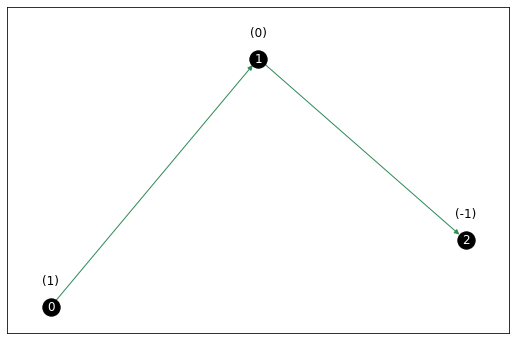

In [9]:
assn_inst.draw_rotation_digraph(augment=False, opt=False, kwargs={'figsize': (9, 6)})

One solution method for the optimal stable assignment works by augmenting the rotation dependency graph and applying a maximum-flow procedure (Irving et al. 1987). However, this method requires adding additional edges for each of the nonzero rotations, which yields an $O(n^2)$ increase in computation time. Further, Irving et al.&rsquo;s augmentation method sometimes produces graphs with no feasible paths even when the candidate-optimal solution is inoptimal overall; our example happens to be one such degenerate case. Thus, I have implemented my own approach.

## Efficient solution via linear programming

I find the optimal stable assignment using a linear program (LP) rather than the maximum-flow procedure.

Let $x_i \in \lbrace 0, 1 \rbrace$ indicate whether rotation $i$ is included in the solution. We seek to maximize the total weight of the rotations we include, namely $1 x_0 + 0 x_1 - 1 x_2$.

By inspecting the directed graph above, we can see that if rotation 2 (on the right) is included, so must rotation 1, and by transitivity rotation 1. This can be expressed by the inequalites $x_2 - x_1 \leq 0$ and $x_1-x_0 \leq 0$.

In the general case, once we have the rotation dependency graph, we can formulate the LP that determines the optimal stable assignment as follows:

$$
\begin{align}
\max \quad & c^T x \\
\text{s.t.} \quad & x_j - x_i \leq 0, & \forall(i,j) \in \mathcal{A} \\
 & 0 \leq x \leq 1
\end{align}
$$

Here $c$ is the vector of rotation weights and $\mathcal{A}$ is the set of directed edges in the rotation graph. Specifying these bounds on $x$ is sufficient to guarantee an integral solution because the constraint matrix in this problem is [totally unimodular](https://en.wikipedia.org/wiki/Unimodular_matrix#Total_unimodularity).

Running a standard LP solver on this example yields $x = (1, 0, 0)$, with a 1-unit decrease in cost compared to the candidate-optimal solution. This means we should eliminate the 0th rotation, whose members were $(0, 3)$ and $(3, 0)$. 

(<networkx.classes.digraph.DiGraph at 0x27045839bb0>,
 [(0, 1), (1, 3), (2, 0), (3, 2)])

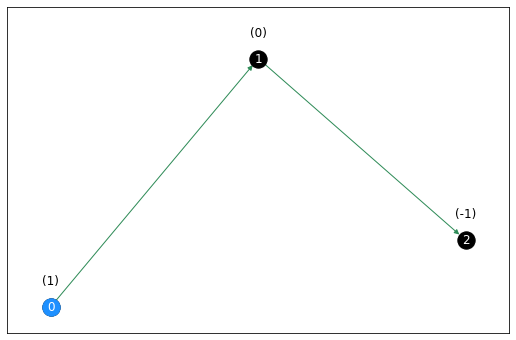

In [10]:
assn_inst.draw_rotation_digraph(kwargs={'figsize': (9, 6)})

The optimal assignment, after eliminating the 0th rotation from the shortlists, is $(0, 1), (1, 3), (2, 0), (3, 2)$.

*N.B.*&emsp;Since many stable assignment programs contain multiple, equivalent optimal solutions, the solver uses a simplex method instead of the (often superior) interior-point method to guarantee that the output is a basic feasible solution.

## Two more examples

Here is the example provided in Irving et al.'s original paper (1987, 535). It contains many rotations. For proof of concept, I provide the normal and reverse forms of the rotation graph; notice that they are each mirror images of the other. The optimal solutions will also complement each other if they are unique, but in this case there are multiple optimal solutions, so they appear different.

Text(0.5, 1.0, 'Rotation flow graph and optimal rotation set, reverse form')

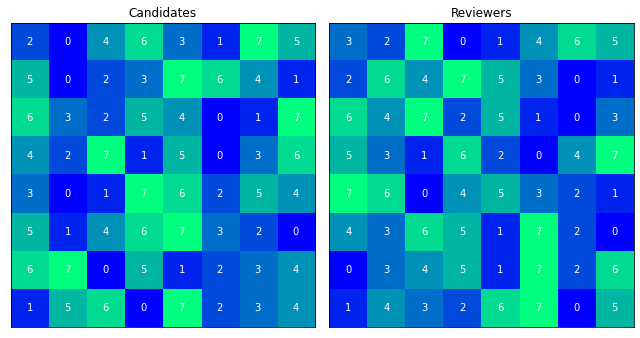

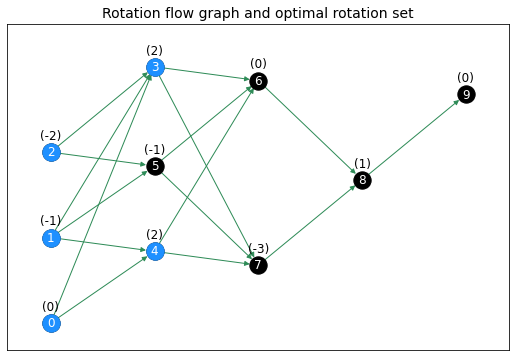

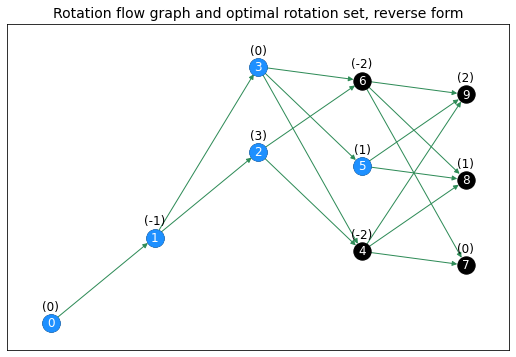

In [11]:
men = (np.array([3,1,5,7,4,2,8,6,
                 6,1,3,4,8,7,5,2,
                 7,4,3,6,5,1,2,8,
                 5,3,8,2,6,1,4,7,
                 4,1,2,8,7,3,6,5,
                 6,2,5,7,8,4,3,1,
                 7,8,1,6,2,3,4,5,
                 2,6,7,1,8,3,4,5]).reshape(8,8) - 1).tolist()
women = (np.array([4,3,8,1,2,5,7,6,
                   3,7,5,8,6,4,1,2,
                   7,5,8,3,6,2,1,4,
                   6,4,2,7,3,1,5,8,
                   8,7,1,5,6,4,3,2,
                   5,4,7,6,2,8,3,1,
                   1,4,5,6,2,8,3,7,
                   2,5,4,3,7,8,1,6]).reshape(8,8) - 1).tolist()
marriage_i = assignment(men, women)

viz_prefs(men, women, {'figsize': (9, 6)})
plt.savefig("exs/viz_prefs.png")

marriage_i.draw_rotation_digraph(kwargs={"figsize": (9, 6)})
plt.title("Rotation flow graph and optimal rotation set", size=14)
plt.savefig("exs/rot_digraph.png")

marriage_i.draw_rotation_digraph(reverse=True, kwargs={"figsize": (9, 6)})
plt.title("Rotation flow graph and optimal rotation set, reverse form", size=14)

For a 9-by-9 problem, Irving et al.&rsquo;s example contains an unusually high number of rotations (and therefore stable assignments). My example is also a an outlier in this regard; I found it by iterating over many 4-by-4 examples until I found one with a large solution space.

Typically, for a problem to contain so many rotations, it needs to be much larger. Here is a representative example of a problem of medium scale (60 by 60): 

<Figure size 864x576 with 0 Axes>

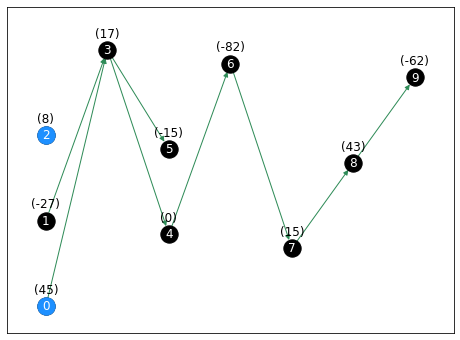

In [12]:
np.random.seed(3454)

m = 60
n = 60

A = [list(np.random.permutation(range(n))) for _ in range(m)]
B = [list(np.random.permutation(range(m))) for _ in range(n)] 

material = assignment(A, B)

plt.figure(figsize=(12,8))
material.draw_rotation_digraph(reverse=False, kwargs={'figsize': (8, 6)})
pass

## Performance

### Typical solution space of randomly generated problems

Asymmetrical problems, and problems where desk rejects are allowed, typically have few or no rotations.

In [13]:
size = 8000

In [14]:
%%script false --no-raise-error
np.random.seed(900)

n = 30
m = 35

n_rotations_1d = []

print("_" * 50)

for i in range(size):
    if (i + 1) % (size / 50) == 0: print("=", end="")

    A = [list(np.random.permutation(range(n)))[:np.random.randint(n/2, n)] for _ in range(m)]
    B = [list(np.random.permutation(range(m)))[:np.random.randint(m/2, m)] for _ in range(n)] 

    material = assignment(A, B)
    n_rotations_1d.append(len(material.rotate()[3]))
    
print()

n_rotations_1d = np.array(n_rotations_1d)
%store n_rotations_1d

Couldn't find program: 'false'


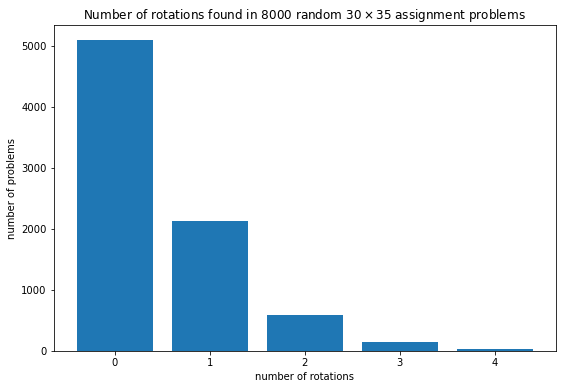

In [15]:
counts = [(n_rotations_1d==i).sum() for i in range(n_rotations_1d.max())]

plt.figure(figsize=(9, 6))
plt.xlabel("number of rotations")
plt.ylabel("number of problems")
plt.title(r"Number of rotations found in {} random $30 \times 35$ assignment problems".format(size))
plt.bar(range(len(counts)), counts)
pass

Symmetrical problems tend to have a larger solution set.

In [16]:
size = 8000
maxn = 100

In [17]:
%%script false --no-raise-error
np.random.seed(8585)

n_participants = []
n_remaining = []
n_edges = []
n_rotations = []

print("_" * 50)

for i in range(size):
    if (i + 1) % (size / 50) == 0: print("=", end="")

    n_i = np.random.randint(3, maxn)

    A = [list(np.random.permutation(range(n_i))) for _ in range(n_i)]
    B = [list(np.random.permutation(range(n_i))) for _ in range(n_i)] 

    material = assignment(A, B)

    n_participants.append(n_i)
    n_remaining.append(sum([len(i) for i in material.proposal()[1]]))
    edges, rp = material.rotation_digraph()[:2]
    n_edges.append(len(edges))
    n_rotations.append(len(rp))

print()

n_participants = np.array(n_participants)
n_remaining = np.array(n_remaining)
n_rotations = np.array(n_rotations)

%store n_participants
%store n_remaining
%store n_edges
%store n_rotations

Couldn't find program: 'false'


[-2.18350205  0.98145474]


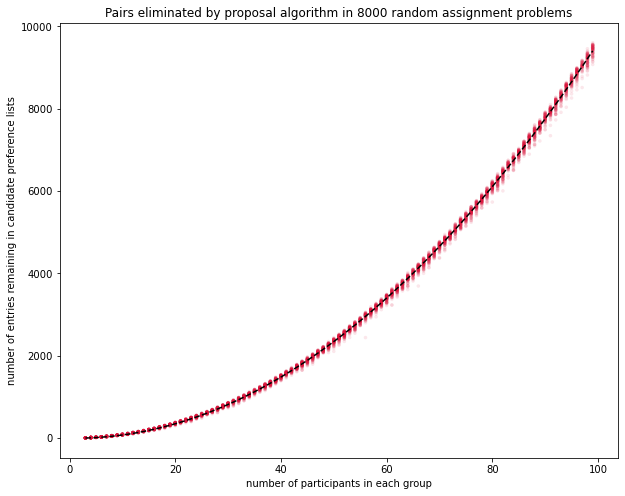

In [18]:
coef = np.linalg.lstsq(np.stack([n_participants, n_participants**2]).T,
                       n_remaining, rcond=None)[0]
print(coef)

fig, ax = plt.subplots(figsize=(10, 8))
x_plot = np.arange(3, maxn)
ax.plot(x_plot, coef @ [x_plot, x_plot**2], color="black", ls="--")
ax.scatter(n_participants, n_remaining, marker=".", color="crimson", alpha=.1, s=50, ec=None)
ax.set_xlabel("number of participants in each group")
ax.set_ylabel("number of entries remaining in candidate preference lists")
ax.set_title("Pairs eliminated by proposal algorithm in {} random assignment problems".format(size))
pass

[-0.02470975  0.99756037]


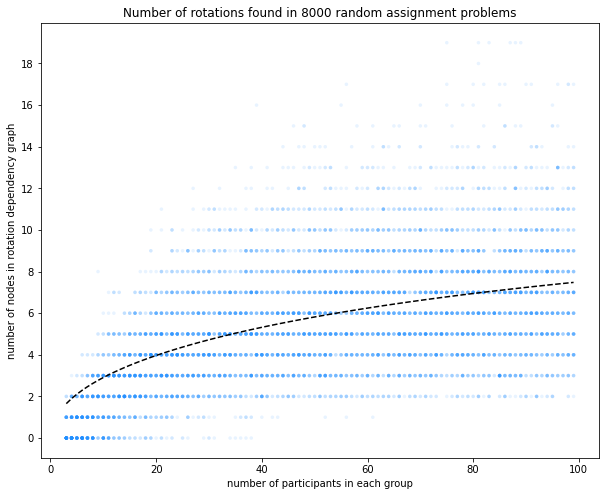

In [26]:
coef = np.linalg.lstsq(np.stack([n_participants, np.sqrt(n_participants)]).T,
                        n_rotations, rcond=None)[0]
print(coef)

fig, ax = plt.subplots(figsize=(10, 8))
x_plot = np.arange(3, maxn)
ax.plot(x_plot, coef @ [x_plot, np.sqrt(x_plot)], color="black", ls="--")
ax.scatter(n_participants, n_rotations, marker=".", color="dodgerblue", alpha=.1, s=50, ec=None)
ax.set_yticks(np.arange(0, 20, 2))
ax.set_xlabel("number of participants in each group")
ax.set_ylabel("number of nodes in rotation dependency graph")
ax.set_title("Number of rotations found in {} random assignment problems".format(size))
pass

[4.07874994e-04 6.77336442e-01]


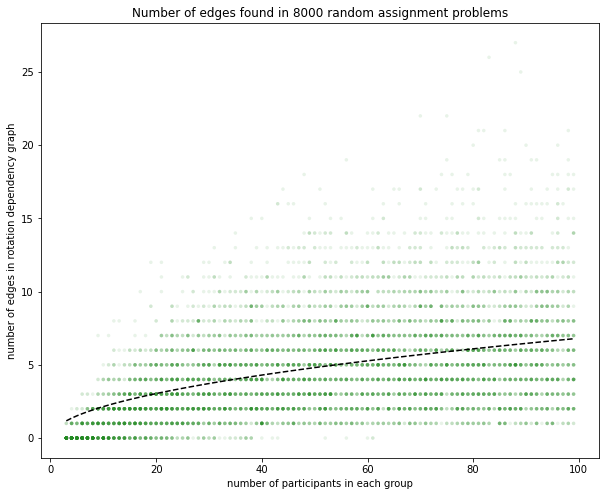

In [20]:
coef = np.linalg.lstsq(np.stack([n_participants, np.sqrt(n_participants)]).T,
                        n_edges, rcond=None)[0]
print(coef)

fig, ax = plt.subplots(figsize=(10, 8))
x_plot = np.arange(3, maxn)
ax.plot(x_plot, coef @ [x_plot, np.sqrt(x_plot)], color="black", ls="--")
ax.scatter(n_participants, n_edges, marker=".", color="forestgreen", alpha=.1, s=50, ec=None)
ax.set_xlabel("number of participants in each group")
ax.set_ylabel("number of edges in rotation dependency graph")
ax.set_title("Number of edges found in {} random assignment problems".format(size))
pass

### Comparison with na&iuml;ve LP formulation 

The optimal stable marriage problem can be formulated as an LP without need of the proposal algorithm. In a $n$-by-$n$ example, let $y_{ij} = 1$ if candidate $i$ is matched with reviewer $j$ and $y_{ij} = 0$ if not. Since each candidate can only be paired with one reviewer, and vice-versa, the sums over $i$ and over $j$ across each $y_{ij}$ must not exceed 1. For a given candidate $i$ and reviewer $j$, the absence of a blocking pair is equivalent to the statement that $y_{ij} + \sum_k y_{k j} + \sum_l y_{i l} \geq 1$. These, taken with nonnegativity in $y$, form the stable marriage polytope. Since the stable marriage polytope is totally unimodular, the stable marriage can be found using this LP, which is easily generalized to the $n$-by-$m$ case (Baïou and  Balinski 2000):

$$
\begin{align}
\min \quad & \sum \left(r_{ij}^{(C)} + r_{ji}^{(R)}\right) y_{ij} \\
\text{s.t.} \quad & \sum_{i=1}^n y_{ij} \leq 1, & \forall j \in \lbrace 1, \dots, n \rbrace \\
& \sum_{j=1}^n y_{ij} \leq 1, & \forall i \in \lbrace 1, \dots, n \rbrace \\
& y_{ij} + \sum_{k=1}^n y_{k j} + \sum_{l=1}^n y_{i l} \geq 1, & \forall(i, j) \in \lbrace 1, \dots, n \rbrace  \times \lbrace 1, \dots, n \rbrace \\
& y \geq 0
\end{align}
$$

Here $r_{ij}^{(C)}$ and $r_{ji}^{(R)}$ indicate candidate $i$&rsquo;s ranking of reviewer $j$, and reviewer $j$&rsquo;s ranking of candidate $i$, respectively. 

This LP has $n^2$ decision variables and $n^2 + 2n$ constraint equations. 

Now, compare the constraint matrix from the rotation formulation:

$$
\begin{align}
\max \quad & c^T x \\
\text{s.t.} \quad & x_j - x_i \leq 0, & \forall(i,j) \in \mathcal{A} \\
 & 0 \leq x \leq 1
\end{align}
$$

Here the number of decision variables equals the number of rotations in the stable assignment set, which is at most $\lfloor \frac{n}{2} \rfloor (n-1)$, because a given layer can contain at most $\lfloor \frac{n}{2} \rfloor$ rotations (each involving only two members), and there are at most $n-1$ depths in the rotation dependency graph. In practice, as we saw above, the number of rotations appears to correlate with $\sqrt{n}$, and I would like to show this mathematically.

The number of constraint equations equals the number of edges, for which I have not yet calculated an upper bound, although the above results suggest it is $O\left(\sqrt{n}\right)$. It is clear that knowing the rotation set for a given assignment problem is an invaluable aid in optimizing over the stable assignment set.

## Extensions

Irving et al. discuss the possibility of using an array of cost values associated with each pairing to create a continuous cost function. Since this formulation of the optimal stable marriage problem is well-suited to situations in which many objective functions are to be compared over the same set of preference lists, I plan to add this functionality soon. For now, the `.cost()` method allows you to supply an external array of cost values to compute the cost of manually entered assignments.

However, my primary interest in the proposal algorithm is its generalization to the one-to-many and many-to-one assignment cases, especially in real-world applications like school choice and university admissions. Baïou and  Balinski (2000) showed that the set of stable many-to-one assignments (the stable admissions polytope) is polyhedral; however, the constraint functions are not as easy to determine as those in the one-to-one case, so the optimal stable admissions problem is considerably more complex than the optimal stable marriage problem. Nonetheless, I hope to add a one-to-many algorithm to this module eventually.

In real-world applications, we often optimize for a combination of several competing objective functions, such as maximizing investment returns while minimizing risk. Bodoh-Creed (2020) developed a procedure for optimal school assignment that balances student preferences against broader distributional goals such as racial diversity. My understanding of Bodoh-Creed&rsquo;s algorithm is that it relies on modeling students&rsquo;s preferences according to a continuous probability distribution. While it outputs matches that are stable with respect to these stochastically modeled preferences, they may not be stable when examining the individual preference lists from which the preference statistics are derived. Since the stable admissions polytope is computationally tractable, I would like to find a way to incorporate arbitrary objective functions into a generalized rotation algorithm that allows for multiple assignment.

## References

Baïou, Mourad and Michel Balinski. 2000. &ldquo;The Stable Admissions Polytope.&rdquo; *Mathematical Programming, Series A* 87: 427&ndash;39.

Bodoh-Creed, Aaron L. 2020. &ldquo;Optimizing for Distributional Goals in School Choice Problems.&rdquo; *Management Science* 66, no. 8 (Sept.): 3657&ndash;76.

Irving, Robert W., Paul Leather, and Dan Gusfield. 1987. &ldquo;An Efficient Algorithm for the &lsquo;Optimal&rsquo; Stable Marriage.&rdquo; *Journal of the Association for Computing Machinery* 34, no. 3 (July): 532&ndash;43.

Roth, Alvin E.,  Uriel G. Rothblum and John H. Vande Vate. 1993. &ldquo;Stable Matchings, Optimal Assignments, and Linear Programming.&rdquo; *Mathematics of Operations Research* 18, no. 4 (Nov.): 803&ndash;28.

In [21]:
!jupyter nbconvert --to html discussion.ipynb

[NbConvertApp] Converting notebook discussion.ipynb to html
[NbConvertApp] Writing 1074044 bytes to discussion.html
